In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import math
import time

In [0]:
%matplotlib inline

In [4]:
from google.colab import files
uploaded = files.upload()

Saving taxi.csv to taxi.csv


# Прогрузим датасет

In [5]:
data = pd.read_csv("taxi.csv")
data.sample(15)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
86847,336800,1,13,277,446666,55.751892,37.582914,55.729983,37.635827,7.485,20.700,VIP,private,0
51578,608886,3,8,4353,822308,55.833156,37.453897,55.832422,37.450206,3.016,6.650,Standard,private,1
34791,937572,4,20,4430,240307,55.752726,37.879682,55.751547,37.954461,1.983,6.433,Standard,private,1
9894,90950,3,19,6580,365142,55.851399,37.440053,55.859618,37.440638,8.593,20.150,Economy,private,0
42801,666721,4,7,6584,529744,55.736547,37.671249,55.744210,37.669563,-1.000,-1.000,Standard,private,1
97218,955745,5,0,6302,806723,55.964894,37.413532,55.962322,37.407117,-1.000,-1.000,Standard,business,0
97926,460352,0,14,6302,442305,55.964894,37.413532,55.962322,37.407117,32.860,34.050,Standard,private,0
64965,496054,5,16,1916,788828,55.769600,37.681743,55.771497,37.686808,2.735,8.817,Economy,private,1
70130,1082415,3,6,4490,757897,55.961926,37.409716,55.964892,37.413543,-1.000,-1.000,Standard,private,0
80960,100441,5,21,5135,487788,55.897187,37.403772,55.885576,37.426132,2.611,9.550,Economy,private,1


# Просмотр данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [7]:
data.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
offer_gk,100000,NaN,NaN,NaN,566219,325936,4,285555,565672,848720,1.13036e+06
weekday_key,100000,NaN,NaN,NaN,3.15986,2.05422,0,1,3,5,6
hour_key,100000,NaN,NaN,NaN,13.8278,7.3065,0,8,16,20,23
driver_gk,100000,NaN,NaN,NaN,3446.38,2038.74,14,1421,3506.5,5242,6806
order_gk,100000,NaN,NaN,NaN,460867,266065,18,229178,462420,690894,920344
driver_latitude,100000,NaN,NaN,NaN,55.7008,2.1359,-1,55.7087,55.7729,55.9607,56.1741
driver_longitude,100000,NaN,NaN,NaN,37.4923,1.45464,-1,37.4135,37.5337,37.6241,38.2805
origin_order_latitude,100000,NaN,NaN,NaN,55.7724,0.665985,-1,55.708,55.7726,55.962,56.3111
origin_order_longitude,100000,NaN,NaN,NaN,37.5416,0.467758,-1,37.4071,37.5325,37.6244,38.2436
distance_km,100000,NaN,NaN,NaN,18.3935,41.1293,-1,-1,10.4115,30.6653,5234.28


* offer_gk - номер предложения: уникален; ***data['offer_gk'].nunique()***
* weekday_key - день недели: 7 элементов;
* hour_key - час: 24 элемента;
* driver_gk - номер водителя; ***data['driver_gk'].nunique()***: 439 элементов с 14 по 6806;
* order_gk - номер заказа ***data[data['order_gk'] == 853342]*** - может соответствовать нескольким офферам. "Почти уникален"
* driver_latitude - координата широты местонахождения водителя; -1 - "Не опеределена"
* driver_longitude - координата высоты местонахождения водителя; -1 - "Не опеределена"
* origin_order_latitude - координата широты заказа; -1 - "Не опеределена"
* origin_order_longitude - координата высоты заказа; -1 - "Не опеределена"
* distance_km - длина поездки в километрах; -1 - "Не опеределена". Есть очень длинные;
* duration_min - продолжительность поездки в минутах; -1 - "Не опеределена". Есть очень долгие;
* offer_class_group - класс поезки; 9 классов (включая тестовый) ***data['offer_class_group'].value_counts()***
* ryde_type_desc - тип поездки; 4 типа;
* driver_response - бинарный признак ответа водителя на предложение о заказе (0 и 1)

# Выявление пропусков

* Есть "неопределенные" значения  = -1;0 для координат:
Т.к. как рассматриваются поездки в Москве; пропусков немного - всего 140 (0,14 % от выборки): можно использовать средние значения широт (медианы) и долгот (Хорошевское шоссе). 
* Длина пути и продожительность поездки "неопределены" синхронно (26359 раз из 100000). Их слишком много, поэтому удаление пустых данных не подходит; Удаление самих признаков тоже не подходит, т.к. они видятся важными (для определения возьмет ли таксит заказ или нет). Использование медиан, средних, мод судя по частотным графикам тоже будет очень грубым допущением. Будем использовать прогнозирование значений. 

In [0]:
# Обработаем координаты
data.loc[data['driver_latitude'] < 55 , 'driver_latitude'] = data['driver_latitude'].median() 
data.loc[data['driver_longitude'] < 35, 'driver_longitude'] = data['driver_longitude'].median() 
data.loc[data['origin_order_latitude'] < 55 , 'origin_order_latitude'] = data['origin_order_latitude'].median() 
data.loc[data['origin_order_longitude'] < 35, 'origin_order_longitude'] = data['origin_order_longitude'].median() 

**Не используем характеристики выборки: по распределению признаков видно, что они дадут очень грубый результат**

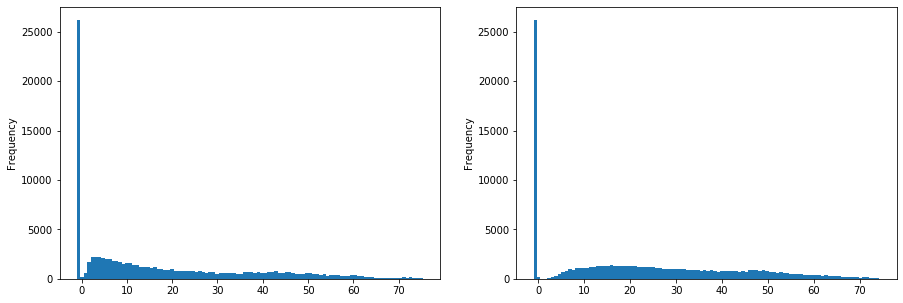

In [9]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
columns = ['distance_km', 'duration_min']

plt.rcParams["axes.labelsize"] = 10
bins_value = 100
i_counter = 0

# Процентали для ограничения данных, чтобы обеспечить наглядность. 
# Из-за выбросов (очень длинных или далеких поездок график был не репрезентативным)

limit_up = 99
limit_down = 0

for i in columns:


    # Выберем данные в пределах проценталей limit_down и limit_up проценталя для наглядности
    p_up = np.percentile(data[i], limit_up)
    p_down = np.percentile(data[i], limit_down)
    
    data1 = data[(data[i] <= p_up) & (data[i] >= p_down)][i]
    data1.plot(kind = 'hist',  ax = axes[i_counter] ,bins = bins_value)
    i_counter += 1
    
plt.show()

In [0]:
data.loc[data['distance_km'].isin([0,-1]),'distance_km'] = np.nan
data.loc[data['duration_min'].isin([0,-1]),'duration_min'] = np.nan

Вернемся к заполнению дистанции и продолжительности поездки после обработки категориальных признаков

# Зависимость переменных

In [11]:
# Посмотрим на корреляцию
data.corr().round(2)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
offer_gk,1.00,-0.00,-0.01,0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,0.01
weekday_key,-0.00,1.00,0.05,0.01,0.00,-0.05,0.03,-0.04,0.03,-0.03,-0.03,0.04
hour_key,-0.01,0.05,1.00,-0.04,0.01,0.05,-0.04,0.05,-0.04,-0.02,-0.03,0.02
driver_gk,0.00,0.01,-0.04,1.00,-0.00,-0.14,0.12,-0.14,0.12,-0.02,-0.01,0.02
order_gk,0.00,0.00,0.01,-0.00,1.00,0.01,-0.01,0.01,-0.01,0.00,0.00,0.00
driver_latitude,-0.00,-0.05,0.05,-0.14,0.01,1.00,-0.69,1.00,-0.70,-0.01,-0.04,-0.20
driver_longitude,-0.01,0.03,-0.04,0.12,-0.01,-0.69,1.00,-0.69,0.99,0.03,0.06,0.16
origin_order_latitude,-0.00,-0.04,0.05,-0.14,0.01,1.00,-0.69,1.00,-0.70,-0.02,-0.04,-0.20
origin_order_longitude,-0.00,0.03,-0.04,0.12,-0.01,-0.70,0.99,-0.70,1.00,0.03,0.06,0.16
distance_km,-0.00,-0.03,-0.02,-0.02,0.00,-0.01,0.03,-0.02,0.03,1.00,0.99,-0.15


In [12]:
# Отчет профайлера
pandas_profiling.ProfileReport(data)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,14
Number of observations,100000
Total Missing (%),1.9%
Total size in memory,10.7 MiB
Average record size in memory,112.0 B
Numeric,8
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,3


Воспользуемся следующими подсказками из профайлера:

* duration_min сильно коррелирует с distance_km;
* origin_order_latitude сильно коррелирует с driver_latitude
* origin_order_longitude сильно коррелирует с driver_longitude

In [0]:
# И удаляем избыточные данные
data.drop(['duration_min','origin_order_latitude','origin_order_longitude'],axis = 1, inplace = True)

# Категориальные признаки

In [14]:
# Посмотрим на категориальные признаки

# Класс поездки
data['offer_class_group'].value_counts()

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

* Уберем тестовые поездки
* Премиальные поездки можно свести в одну группу

In [0]:
data.loc[data['offer_class_group'] == 'VIP+', 'offer_class_group'] = 'VIP'
data = data[data['offer_class_group'] != 'Test']

In [16]:
# Тип поездки
data['ride_type_desc'].value_counts()

private      91207
business      8533
affiliate      224
SMB             28
Name: ride_type_desc, dtype: int64

Доля обычных частных и бизнес поездок > 99%. Остальные типы объединим в агрегатный тип 'Other'

In [0]:
# Тип поездки не private и не business
data.loc[~data['ride_type_desc'].isin(['private', 'business']) , 'ride_type_desc'] = 'other'

In [0]:
# Применим one-hot-encoding к offer_class_group
one_hot = pd.get_dummies(data['offer_class_group'])
# Удаляем колонку 
data.drop(['offer_class_group'], axis = 1, inplace = True)
# добавляем колонку one-hot к исходной таблице
data = data.join(one_hot)

In [0]:
# Применим one-hot-encoding к ride_type_desc
one_hot = pd.get_dummies(data['ride_type_desc'])
# Удаляем колонку 
data.drop(['ride_type_desc'], axis = 1, inplace = True)
# добавляем колонку one-hot к исходной таблице
data = data.join(one_hot)

In [20]:
# Нормализуем данные, выделим целевое значение
from sklearn import preprocessing

X = data.drop(['driver_response'], axis = 1)
y = data['driver_response']

#Задаем максимум и минимум новой нормализованной выборки через feature_range
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# Запоминаем названия столбцов
headers = list(X.columns.values)

# Трансформируем регрессоры, масштабируя каждую переменную к указанному диапазону
# Получааем построчный numpy array
np_scaled = min_max_scaler.fit_transform(X)

# Преобразуем в DataFrame
X_norm = pd.DataFrame(np_scaled)

# Восстанавливаем названия столбцов
X_norm.columns = headers
X_norm.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,distance_km,Delivery,Economy,Kids,Premium,Standard,VIP,XL,business,other,private
0,0.977899,0.833333,0.869565,0.89311,0.189242,0.580306,0.269947,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.672118,0.833333,0.608696,0.89311,0.389814,0.564357,0.409216,0.003591,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.368888,1.000000,0.608696,0.89311,0.941234,0.574559,0.280077,0.001288,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.787062,0.333333,0.260870,0.89311,0.177659,0.494159,0.337232,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.990888,0.666667,0.695652,0.89311,0.550557,0.562273,0.414293,0.002365,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Заполняем длину поездки

* KNNImputer и fancyimpute требует очень много RAM для выполнения (даже с 25 GB в Colab не отрабатывает)
* Поэтому напишем KNN руками

In [0]:
def fill_KNN_manual(row, df, k):
    """
    1. Расчет  евклидовой нормы между строкой и всеми остальными строками
    2. Расчет  среднего расстояния между ближайшими k точками
    
    НЕ ИСПОЛЬЗУЕТСЯ
    
    """
    # Сюда складываем key - индекс строки; values - значение нормы
    row_dict = {}
    
    
    # Выбираем только те строки, где нужно посчитать расстояние
    if  np.isnan(row['distance_km']) == False:
        
        return row['distance_km']
    
    else:

        # Сравниваем строку со всеми строками фрейма
        for ind in df.index: 
            
            # Если рассатриваемая строка row совпадает со строкой фрейма
            # или если в строки фрейме distance_km не определен
            # то вычисления не производим (сравнение самой с собой или запись с которой нельзя обучиться)
            if ((ind != row.name) & (np.isnan(df['distance_km'][ind]) == False)):
                
                # Евклидова норма 
                eu_norm = 0

                # Проходим по столбцам фрейма
                for column in df.columns:

                    # Чтобы сравнить элемент текущей строки с соответсвующим элементом строки row
                    # нужно получить порядковый номер столбца
                    i = df.columns.get_loc(column)
                    
                    # Если столбец distance_km, то расчет не производим
                    if column != 'distance_km':
                        
                        # Считаем квадрат разности координат и добавляем к норме
                        eu_norm += (row[i] - df[column][ind])**2
            
            
                # Добавляем норму в словарь
                
                row_dict[ind] = math.sqrt(eu_norm)
                #print(row.name, ind, eu_norm)
        
        # Находим k индексов элементов с наименьшими нормами
        
        min_eu_norms = sorted(row_dict, key = row_dict.get)[:k]
        #print(min_eu_norms)
        
        
        # Получаем среднее растояние среди найденных элементов (без взвешивания) и возвращаем полученный результат
        result = 0
        
        for i in min_eu_norms:
            result += df['distance_km'][i]
        
        result = result / len(min_eu_norms)
        
        return result

# На 10000 строках отрабатывает за 4h 37min 58s

Т.к. временные затраты написанной функции неприемлимы - модифицируем алгоритм:
    * Добавим параметр dim - размер выборки, на которой производим расчет (т.е. "соседей" ищем не во всей выборке а только из выбранного множества dim);
    * n_count - кол-во итераций выборов случайных подмножеств для расчета среднего значения distance_km;

In [0]:
# KNN и fancyimpute требует очень много RAM для выполнения (даже с 25 GB в Colab не отрабатывает)
# Поэтому напишем KNN руками

def fill_KNN_manual_modified(row, df, k, dim, n_count):
    """
    1. Расчет  евклидовой нормы между строкой и всеми выбранными dim элементами
    2. Расчет  среднего расстояния между ближайшими k точками (из dim)
    3. Кол-во итераций расчета: n_count;
    4. Расчет среднего по итерациям
    """

    #print(": \n", "Start row", row.name)
    
    # Выбираем только те строки, где нужно посчитать расстояние
    if  np.isnan(row['distance_km']) == False:
        
        #print("Для ", row.name, 'копируем:  ', row['distance_km'])
        return row['distance_km']
    
    else:

        distances = {}
        
        # Количество итераций расчета расстояний
        for it in range(0,n_count):

            # Сравниваем строку с выбранными cлучайным образом строками фрейма
            df_s = df.sample(dim) 
            
            # Сюда складываем key - индекс строки; values - значение нормы
            row_dict = {} 

            for ind in df_s.index:             

                # Если рассатриваемая строка row совпадает со строкой фрейма
                # или если в строки фрейме distance_km не определен
                # то вычисления не производим (сравнение самой с собой или запись с которой нельзя обучиться)
                if ((ind != row.name) & (np.isnan(df_s['distance_km'][ind]) == False)):
           
                    # Евклидова норма 
                    eu_norm = 0

                    # Проходим по столбцам фрейма
                    for column in df_s.columns:

                        # Чтобы сравнить элемент текущей строки с соответсвующим элементом строки row
                        # нужно получить порядковый номер столбца
                        i = df_s.columns.get_loc(column)

                        # Если столбец distance_km, то расчет не производим
                        if column != 'distance_km':

                            # Считаем квадрат разности координат и добавляем к норме

                            eu_norm += (row[i] - df_s[column][ind])**2

                    # Добавляем норму в словарь

                    row_dict[ind] = math.sqrt(eu_norm)
                    #print(row.name, ind, " Норма: " , row_dict[ind])

            # Находим k индексов элементов с наименьшими нормами

            min_eu_norms = sorted(row_dict, key = row_dict.get)[:k]    

            # Получаем среднее растояние среди найденных элементов (без взвешивания) и возвращаем полученный результат
            result = 0

            for i in min_eu_norms:
                result += df_s['distance_km'][i]

            result = result / len(min_eu_norms)
            
            # В рамках итерации получили расчетное расстояние 
            distances[it] = result
            #print(row.name, " Полученные расстояния: ", distances[it])
            
 
        # Возьмем среднее по итерациям:
        
        result = 0
        for value in distances.values():
            result += value
        
        result = result / len(distances)
        #print("Для ", f'{row.name}', "результат: ", result)
        
        return result

In [23]:
%%time
X_norm['distance_km_KNN'] = X_norm.apply(fill_KNN_manual_modified, df = X_norm, k = 5, dim = 25, n_count = 4, axis = 1)

CPU times: user 20min 42s, sys: 2.84 s, total: 20min 44s
Wall time: 20min 45s


# Обучим модель: ДЕРЕВО РЕШЕНИЙ

In [0]:
X_norm.drop(['distance_km'], axis = 1, inplace = True)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3)

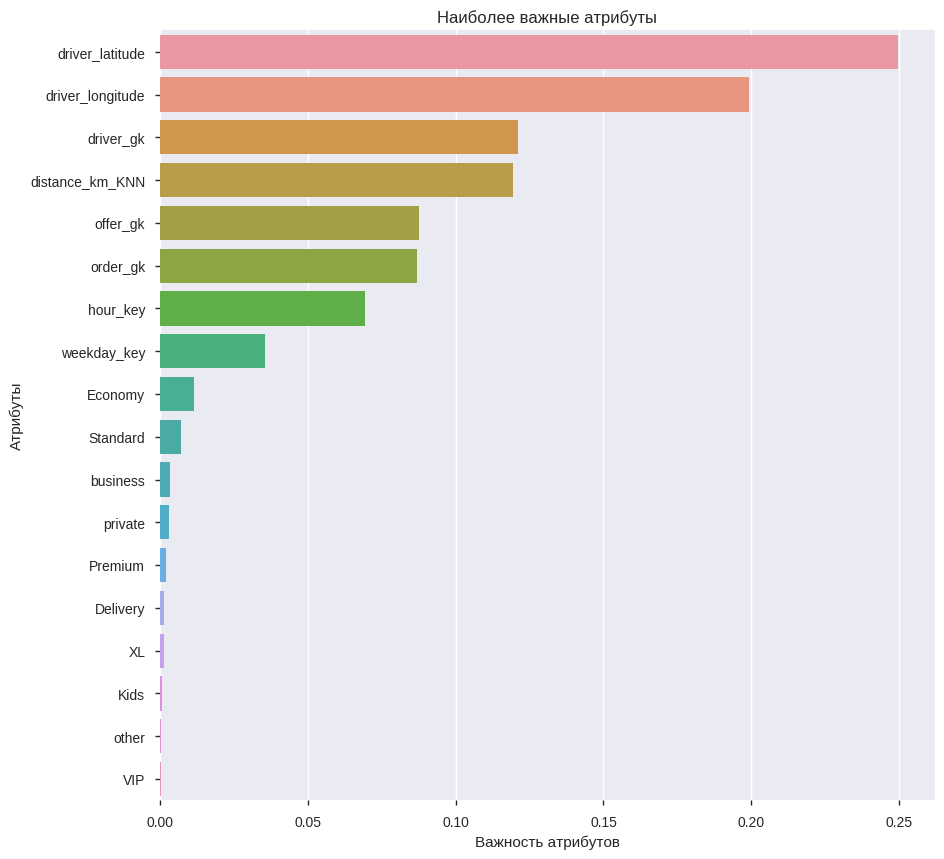

In [26]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators = 100)

# обучаем модель
model.fit(X_train,y_train)

headers = list(X_train.columns.values)

# вклад каждого из регрессоров в целевое значение, 
feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
#plt.legend()
plt.show()

In [27]:
from sklearn.metrics import classification_report

model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
model.score(X_test, y_test)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81     15335
           1       0.78      0.86      0.82     14663

    accuracy                           0.82     29998
   macro avg       0.82      0.82      0.82     29998
weighted avg       0.82      0.82      0.82     29998



0.8155543702913528

# РЕЗУЛЬТАТ в 82 %